In [160]:
from src.agents import Agent
from src.utils import normalize, extract_walls_from_geometry
from shapely.geometry import Polygon, Point
import numpy as np
import pandas as pd
import pedpy
import jupedsim as jps
from jupedsim.internal.notebook_utils import animate
from src.parameters import ForceParameters
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
# Sign parameters
from shapely import wkt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [161]:
geometry_file = "data/geometry.wkt"
with open(geometry_file, "r") as myfile:
    data = myfile.read().strip()

geometry_collection = wkt.loads(data)
polygons = list(geometry_collection.geoms)  # Unpack main-level geometries

# Extract walkable area
area = polygons[0].geoms[0]
area_no_holes = Polygon(area.exterior.coords)
signs = polygons[0].geoms[0].interiors
sign_points = [np.array(sign.centroid.coords[0]) for sign in signs]
#sign_points = [np.array([70., 17.]), np.array([49., 37.]), np.array([68.5, 37. ])]
sign_orientations = [np.array([80, 5])-np.array([70., 17.]), [1,-1], [0,-1]]

sign_points = sign_points[:-1]
sign_orientations = sign_orientations[:-1]
# Extract exits (second collection)
exit_polygons = []
if len(polygons) > 1:
    exits = polygons[1]
    exit_polygons = list(exits.geoms)

# Extract distributions (third collection)
distribution_polygons = []
if len(polygons) > 2:
    distributions = polygons[2]
    distribution_polygons = list(distributions.geoms)

print(f"Exits: {len(exit_polygons)} polygons")
print(f"Distributions: {len(distribution_polygons)} polygons")

Exits: 3 polygons
Distributions: 1 polygons


In [162]:
def plot_geometry(geometry_collection,  vision_radius =20.0, positions=None):
    """Plot the geometry collection with different colors for each geometry type."""
    fig, ax = plt.subplots(figsize=(8, 8))
    if geometry_collection.is_empty:
        print("Skipping empty geometry.")
        return
    polygons = list(geometry_collection.geoms)  # Unpack main-level geometries
    area = polygons[0] if len(polygons) > 0 else None
    # Extract exits (second collection)
    if len(polygons) > 1:
        exits = polygons[1]

    # Extract distributions (third collection)
    if len(polygons) > 2:
        distributions = polygons[2]

    for geom in area.geoms:
        x, y = geom.exterior.xy
        plt.fill(x, y, alpha=0.2,  edgecolor="black", facecolor="gray")
    
    # Plot signs and their cones
   
    sign_fov_angle = np.pi/2.0
    for i, (pos, orient) in enumerate(zip(sign_points, sign_orientations)):
        # Normalize orientation
        orient = orient / np.linalg.norm(orient)

        # Sign point and direction
        ax.plot(*pos, 'bo')
        ax.arrow(*pos, *(orient * 2), head_width=0.2, color='blue')

        # Draw vision wedge for each sign
        angle_deg = np.degrees(np.arctan2(orient[1], orient[0]))
        wedge = plt.matplotlib.patches.Wedge(
            pos, vision_radius,
            theta1=angle_deg - np.degrees(sign_fov_angle) / 2,
            theta2=angle_deg + np.degrees(sign_fov_angle) / 2,
            facecolor='lightblue', alpha=0.3, edgecolor='blue'
        )
        ax.add_patch(wedge)
        ax.text(pos[0]+0.4, pos[1]+0.4, f"S{i}", fontsize=12)



    for e in exits.geoms:
        x, y = e.exterior.xy
        plt.fill(x, y, alpha=0.3, color="red")

    for d in distributions.geoms:
        x, y = d.exterior.xy
        plt.fill(x, y, alpha=0.3, color="green")

    if positions is not None:
        for position in positions:
            x, y = position[0], position[1]
            plt.plot(x, y, "o", color="blue")

    legend_elements = {
        "area": mpatches.Patch(color="gray", label="Walkable Area"),
        "signs": mpatches.Patch(color="blue", label="Signs"),
        "exits": mpatches.Patch(color="red", label="Exits"),
        "distribution": mpatches.Patch(color="green", label="Distribution Zones"),
    }
    handles = [
        legend_elements[key]
        for key in ["area", "signs", "exits", "distribution"]
        if key in legend_elements
    ]
    ax.legend(
        handles=handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.05),
        ncol=len(handles),
        frameon=False,
    )
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_aspect("equal")
    plt.show()
    

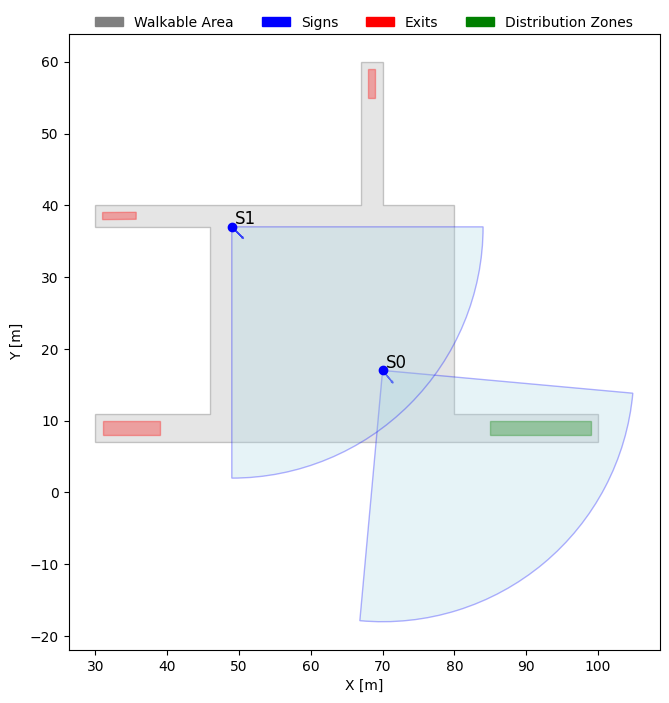

In [163]:
plot_geometry(geometry_collection, vision_radius=35)

In [164]:
params = ForceParameters(
    a=0.2,
    wall_distance=1,
    wall_strength_always=3.,
    wall_strength_into=4.,
    exit_strength=1,
    exit_domain_radius = 100.0,
    q1=0.5,
    q2=0.2, # q2< q1
    eta_mem=0,
    eta_sign=0,
    hi=1,
    sign_vision_radius= 35,
    fov_angle= np.pi * 2 / 3,  # 120 degrees
)
dt, steps = 0.01, 3000
num_agents = 10

In [ ]:
# Run simulation
distribution = distribution_polygons[0]
walls = extract_walls_from_geometry(area_no_holes)
exits = exit_polygons
positions = jps.distribute_by_number(
    polygon=Polygon(distribution),
    number_of_agents=num_agents,
    distance_to_agents=0.4,
    distance_to_polygon=0.2,
)

agents = []
for idx, position in enumerate(positions):
    agent = Agent(position=position, id=idx,velocity=[-1.0, 0.0], params=params)
    agents.append(agent)

active_agents = list(range(len(agents)))  # keep track of active agent indices

sign_position_orientation = [(position, orientation) for position, orientation in zip(sign_points, sign_orientations)]
# Simulation
trajectories = []
for frame in range(steps):
    # Store next state separately to avoid updates affecting other agents' inputs
    next_positions = []
    next_velocities = []
    # for agent1 in agents: calculate the influnce of all other agents
    print(f"{frame = }", end="\r")
    for i in active_agents:
        agent = agents[i]
        # Gather others (positions and velocities)
        others = [(agents[j].x, agents[j].v) for j in active_agents if j != i]

        # Compute forces and update
        agent.compute_forces(others, walls, signs=sign_position_orientation, exits=exits, x_panic=[100, 9])
        agent.update(dt)

        o = normalize(agent.v)
        trajectories.append(
            {
                "frame": frame,
                "id": i,
                "x": agent.x[0],
                "y": agent.x[1],
                "ox": o[0],
                "oy": o[1],
            }
        )

    # Remove agents who have reached the exit
    still_active = []
    for i in active_agents:
        if not Point(agents[i].x).within(exits[0]):
            still_active.append(i)
        
    active_agents = still_active

    # Stop early if all agents are done
    if not active_agents:
        break
# Convert to DataFrame
df = pd.DataFrame(trajectories)

<Axes: xlabel='x/m', ylabel='y/m'>

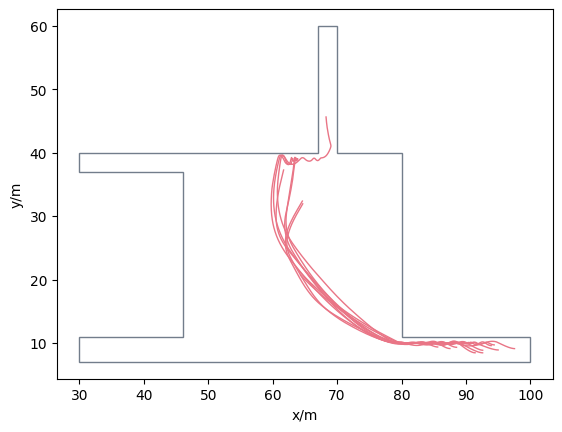

In [166]:
traj = pedpy.TrajectoryData(data=df, frame_rate=1/dt)
walkable_area = pedpy.WalkableArea(polygon=area_no_holes)
pedpy.plot_trajectories(walkable_area=walkable_area, traj=traj)

In [167]:
animate(data=traj, area=walkable_area, every_nth_frame=20, title_note="Hirai & Tarui, 1975")

## Debugging

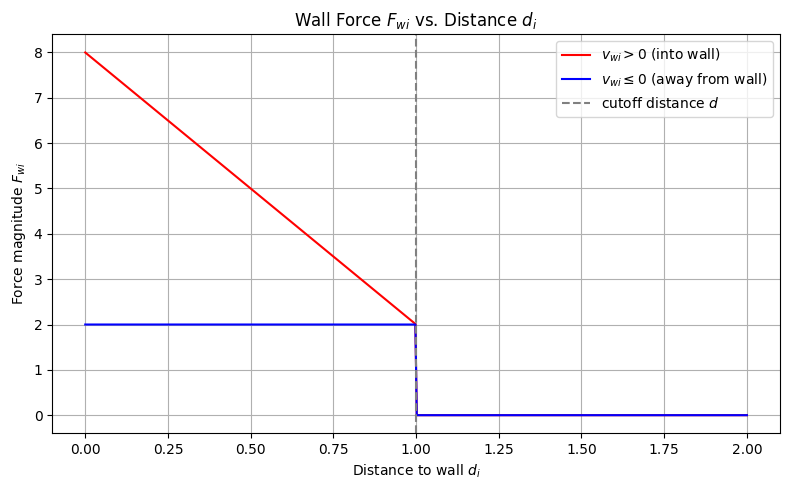

In [168]:
# Parameters
w0 = 6.0
w1 = 2.0
d_cutoff = 1.0  # d in the equation

# Distances to wall
d_i = np.linspace(0, 2, 500)  # covers both d_i < d and d_i > d

# Velocity component into the wall
v_wi_positive = 1.0  # into the wall (v_wi > 0)
v_wi_negative = -1.0  # away from the wall (v_wi <= 0)

# Force magnitudes
F_positive = np.where(d_i < d_cutoff,
                      (w0 * v_wi_positive * (d_cutoff - d_i) / d_cutoff + w1),
                      0)

F_negative = np.where(d_i < d_cutoff,
                      w1,
                      0)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(d_i, F_positive, label=r"$v_{wi} > 0$ (into wall)", color="red")
plt.plot(d_i, F_negative, label=r"$v_{wi} \leq 0$ (away from wall)", color="blue")
plt.axvline(x=d_cutoff, color="gray", linestyle="--", label="cutoff distance $d$")
plt.xlabel(r"Distance to wall $d_i$")
plt.ylabel(r"Force magnitude $F_{wi}$")
plt.title("Wall Force $F_{wi}$ vs. Distance $d_i$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


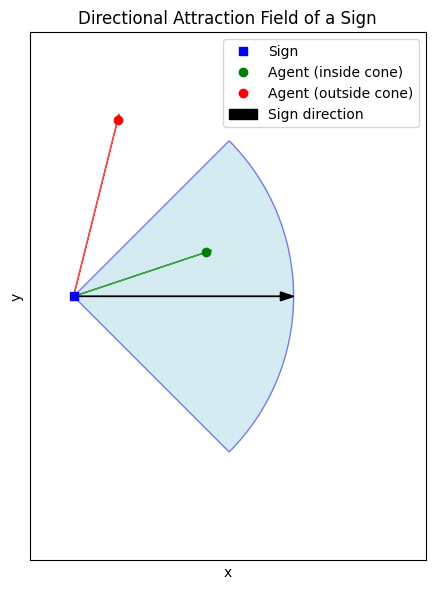

In [169]:
sign_position = np.array([0, 0])
sign_orientation = np.array([1.0, 0.0])  # Points to the right
vision_radius = 5.0
sector_angle_deg = 90  # Degrees
sector_angle_rad = np.radians(sector_angle_deg)

# Agent positions
agent_inside_cone = np.array([3, 1])    # should be affected
agent_outside_cone = np.array([1, 4])   # should NOT be affected
agent_direct_ahead = np.array([4, 0])   # strong attraction

# Prepare the figure
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')

# Draw vision cone (as Wedge)
start_angle_deg = -sector_angle_deg / 2
wedge = Wedge(
    sign_position,
    vision_radius,
    theta1=np.degrees(np.arctan2(sign_orientation[1], sign_orientation[0])) + start_angle_deg,
    theta2=np.degrees(np.arctan2(sign_orientation[1], sign_orientation[0])) + start_angle_deg + sector_angle_deg,
    facecolor="lightblue",
    alpha=0.5,
    edgecolor="blue"
)
ax.add_patch(wedge)

# Draw sign as a point
ax.plot(*sign_position, 'bs', label='Sign')

# Draw agents
ax.plot(*agent_inside_cone, 'go', label='Agent (inside cone)')
ax.plot(*agent_outside_cone, 'ro', label='Agent (outside cone)')

# Vectors from sign to agents
for agent, color in zip([agent_inside_cone, agent_outside_cone], ['green', 'red']):
    vec = agent - sign_position
    ax.arrow(sign_position[0], sign_position[1], vec[0], vec[1], head_width=0.1, color=color, alpha=0.7)

# Arrow for sign orientation
ax.arrow(*sign_position, *(sign_orientation * vision_radius*0.94), head_width=0.2, color="black", label="Sign direction")

ax.set_xlim(-1, 8)
ax.set_ylim(-6, 6)
# equal axis
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
# no ticks on axis
ax.set_xticks([])
ax.set_yticks([])
ax.legend()
plt.title("Directional Attraction Field of a Sign")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


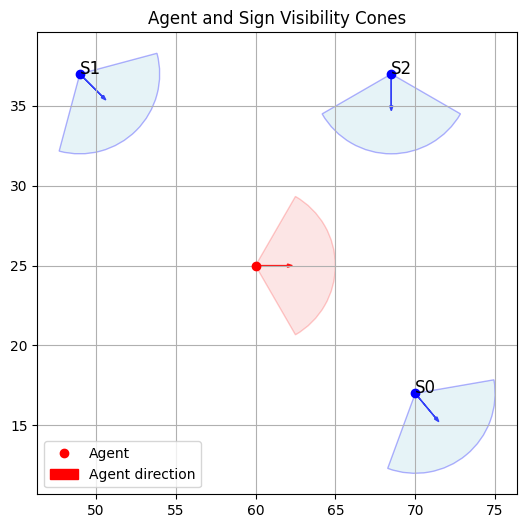

In [170]:
import matplotlib.pyplot as plt
import numpy as np

# Sign positions (from centroids)
sign_points = [np.array([70., 17.]), np.array([49., 37.]), np.array([68.5, 37. ])]
sign_orientations = [np.array([80, 5])-np.array([70., 17.]), [1,-1], [0,-1]]

# Agent position
agent_pos = np.array([60, 25])
agent_velocity = np.array([1, 0])

# Vision parameters
vision_radius = 5.0
agent_fov_angle = np.pi * 2 / 3  # 120 degrees
sign_fov_angle = np.pi * 2 / 3  # 120 degrees

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect('equal')

# Agent
ax.plot(*agent_pos, 'ro', label='Agent')
ax.arrow(*agent_pos, *(agent_velocity * 2), head_width=0.2, color='red', label='Agent direction')


sign_points = [np.array([70., 17.]), np.array([49., 37.]), np.array([68.5, 37. ])]
sign_orientations = [np.array([80, 5])-np.array([70., 17.]), [1,-1], [0,-1]]
# Plot signs and their cones
for i, (pos, orient) in enumerate(zip(sign_points, sign_orientations)):
    # Normalize orientation
    orient = orient / np.linalg.norm(orient)

    # Sign point and direction
    ax.plot(*pos, 'bo')
    ax.arrow(*pos, *(orient * 2), head_width=0.2, color='blue')

    # Draw vision wedge for each sign
    angle_deg = np.degrees(np.arctan2(orient[1], orient[0]))
    wedge = plt.matplotlib.patches.Wedge(
        pos, vision_radius,
        theta1=angle_deg - np.degrees(sign_fov_angle) / 2,
        theta2=angle_deg + np.degrees(sign_fov_angle) / 2,
        facecolor='lightblue', alpha=0.3, edgecolor='blue'
    )
    ax.add_patch(wedge)
    ax.text(pos[0], pos[1], f"S{i}", fontsize=12)

# Draw agent field of view as wedge
agent_angle_deg = np.degrees(np.arctan2(agent_velocity[1], agent_velocity[0]))
agent_wedge = plt.matplotlib.patches.Wedge(
    agent_pos, vision_radius,
    theta1=agent_angle_deg - np.degrees(agent_fov_angle) / 2,
    theta2=agent_angle_deg + np.degrees(agent_fov_angle) / 2,
    facecolor='lightcoral', alpha=0.2, edgecolor='red'
)
ax.add_patch(agent_wedge)

#ax.set_xlim(-2, 10)
#ax.set_ylim(-3, 8)
ax.set_title("Agent and Sign Visibility Cones")
ax.grid(True)
ax.legend()
plt.show()
